# Eksperimen

In [74]:
#library Preprocessing
!pip install Sastrawi

import string
import re
import numpy as np
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#library feature extraction/classifier/evaluation
from sklearn import preprocessing, model_selection, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#library visualization
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
np.random.seed(123)

In [41]:
#Baca Dataset
data = pd.read_csv("Dataset.csv",sep=";", encoding='utf-8')

In [10]:
data.head()

,Value,tweet
0,Positif,@Tiger_super09 @PLindungi thx infonya
1,Positif,@choc0oojull @PLindungi Kalau gak bisa kasih s...
2,Positif,@choc0oojull @PLindungi Coba suruh orang yang ...
3,Positif,@choc0oojull @PLindungi Doi siape wkwkwk tp ak...
4,Positif,"@Tiger_super09 @PLindungi udahh, ngga responsi..."


In [43]:
#funtcion hapus tanda baca dan @
def remove_punctuation_and_number(text):
    text = re.sub("@[A-Za-z0-9]+","",text)  
    text = re.sub("_[A-Za-z0-9]+","",text)
    text = re.sub(r"\d+","",text)
    for sp in string.punctuation:
        text = text.replace(sp, " ")
    return text.replace('/\s\s+/g', ' ')

data['tweet'] = data['tweet'].apply(remove_punctuation_and_number)

In [44]:
data['tweet'][3]

'  Doi siape wkwkwk tp aku dapet sms   nya'

In [45]:
#stopword
sw = ["aja","agan","barang","beli","baru","ada","adalah","ajaa","akan","aku","atas","buat","boss","agak","agar","apa","biar","bsa","alhmdulillah","alhamdulilah","akhir","allah","ane","arn","atau","audah","bang","aaaa","about","adik","ah","admin","and","as","bakalan","barank","amin","begini","begitu","beberapa"]

#function hapus stopword
def stopwords(text):
    '''a function for removing the stopword'''
    import re
    text = [word.lower() for word in text.split()]
    for word in text:
        for stop in sw:
            if word==stop:
                text.remove(word)
    text = " ".join(text)
    text = re.sub(r'(.+?)\1+', r'\1',text)
    return text

data['tweet'] = data['tweet'].apply(stopwords)

In [46]:
#stemming - hapus imbuhan
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)
data['tweet'] = data['tweet'].apply(stemming)

     |████████████████████████████████| 209 kB 5.3 MB/s 


In [142]:
#konversi label ke numeric type
def labelToNumeric(category):
        if category == 'Negatif':
          return 0
        elif category == 'Positif':
          return 1
        else :
          return 0
data['category'] = data['Value'].apply(labelToNumeric)

In [143]:
data['category'].value_counts()

0    637
1    545
Name: category, dtype: int64

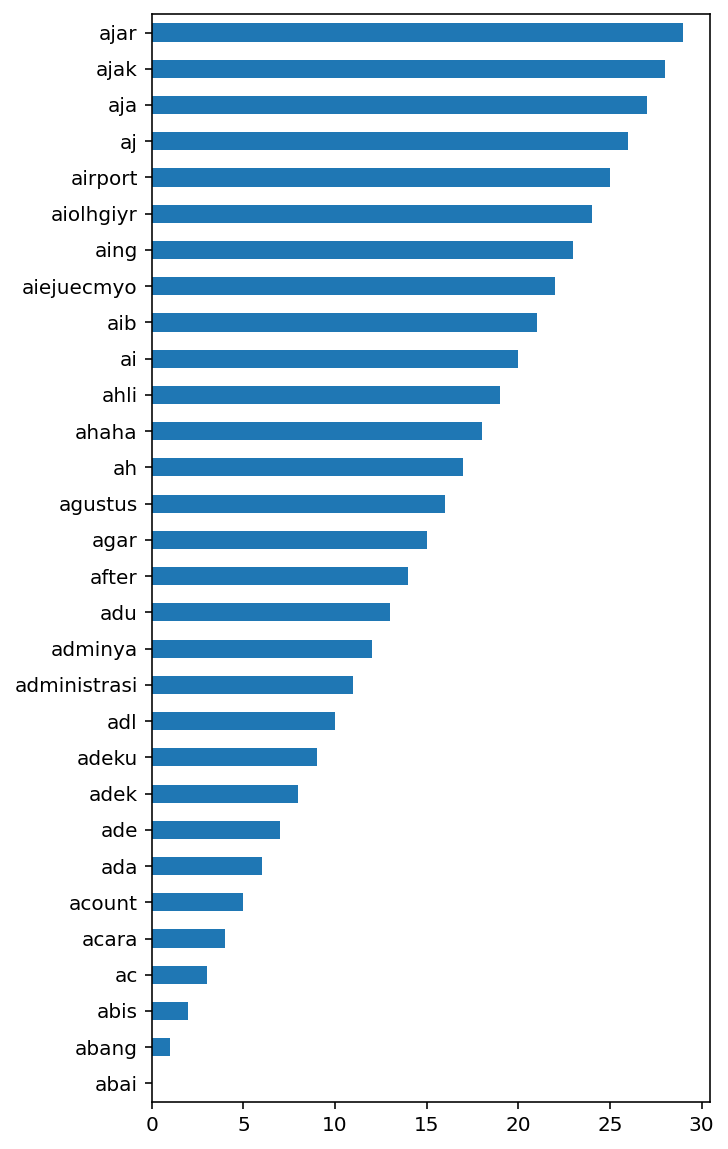

In [47]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(data['tweet'])
dictionary = tfidf_vectorizer.vocabulary_.items()  
vocab = []
count = []
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
vocab_bef_stem = pd.Series(count, index=vocab)
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=True)
top_vacab = vocab_bef_stem.head(30)
top_vacab.plot(kind = 'barh', figsize=(5,10))

In [121]:
#split dataset
X_train, X_test, y_train, y_test = model_selection.train_test_split( data['tweet'], data['category'], test_size=0.3, random_state=42)

In [122]:
#feature extraction/pembobotan menggunakan TF-IDF
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['tweet'])
X_train = Tfidf_vect.transform(X_train)
X_test = Tfidf_vect.transform(X_test)

In [123]:
X_train

<827x2826 sparse matrix of type '<class 'numpy.float64'>'
	with 14684 stored elements in Compressed Sparse Row format>

In [130]:
#inisialisasi model SVM menggunakan beberapa parameter
model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

#fitting dataset ke model
model.fit(X_train,y_train)

#prediksi
y_pred = model.predict(X_test)

#evaluasi performa
print("SVM Accuracy Score -> ",accuracy_score(y_test, y_pred)*100)

SVM Accuracy Score ->  84.22535211267605


In [126]:
#evaluasi performa lebih baik mengguankan f1 score ketika dataset imbalance
f1_score(y_test, y_pred, average='macro')

0.8383739837398374

In [127]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.96      0.86       185
           1       0.94      0.72      0.81       170

    accuracy                           0.84       355
   macro avg       0.86      0.84      0.84       355
weighted avg       0.86      0.84      0.84       355



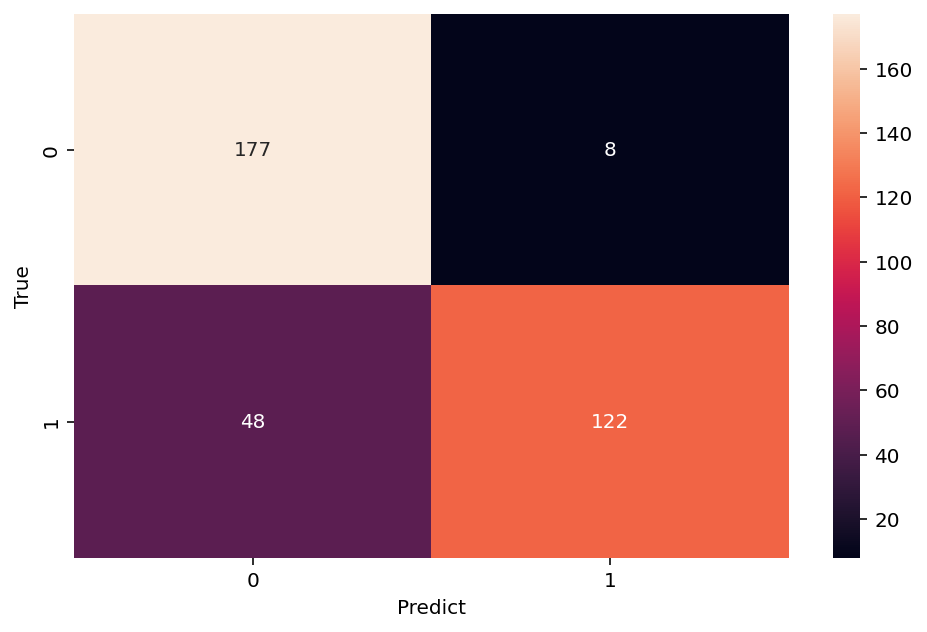

In [129]:
#Ketika grafik menunjukan matriks diagonal maka percobaan yang sudah dilakukan dapat dinyatakan valid
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predict")
plt.ylabel("True")
plt.show()

# Oversampling
Oversamping dilakukan ketika dataset tidak seimbang

In [139]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=12)
train_data_ros, y_train_ros = ros.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [140]:
model_ros = svm.SVC()

model_ros.fit(train_data_ros,y_train_ros)
y_pred_ros = model_ros.predict(X_test)
model_ros.score(X_test,y_test)

0.8309859154929577

In [141]:
print(classification_report(y_test, y_pred_ros))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       185
           1       0.95      0.68      0.79       170

    accuracy                           0.83       355
   macro avg       0.86      0.82      0.83       355
weighted avg       0.86      0.83      0.83       355



In [136]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [137]:
model_smote = svm.SVC()

model_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = model_smote.predict(X_test)
model_smote.score(X_test,y_test)

0.8084507042253521

In [138]:
print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       185
           1       0.95      0.64      0.76       170

    accuracy                           0.81       355
   macro avg       0.85      0.80      0.80       355
weighted avg       0.84      0.81      0.80       355

